# Semeval 2025 Task 10
### Subtask 2: Narrative Classification

Given a news article and a [two-level taxonomy of narrative labels](https://propaganda.math.unipd.it/semeval2025task10/NARRATIVE-TAXONOMIES.pdf) (where each narrative is subdivided into subnarratives) from a particular domain, assign to the article all the appropriate subnarrative labels. This is a multi-label multi-class document classification task.

In [1]:
random_state=None

In [2]:
import torch
import numpy as np
import random

if random_state:
    print('[WARNING] Setting random state')
    torch.manual_seed(random_state)
    np.random.seed(random_state) 
    random.seed(random_state)

## Heatmap Classifier

Instead of having separate heads predicting narratives and subnarratives, we can have a single feed-forward network producing a 2D output per article where:

* Rows = Narratives
* Columns = Subnarratives
* Each cell value = Probability that article belongs to that narrative-subnarrative pair

The arch is a simpler, because it's just predicting a heatmap similar to image classification per pixel rather than managing multiple prediction heads.

In [3]:
import pickle
import os
import pandas as pd

root_dir = "../../"
base_save_folder_dir = '../saved/'
dataset_folder = os.path.join(base_save_folder_dir, 'Dataset')

with open(os.path.join(dataset_folder, 'dataset_train_cleaned.pkl'), 'rb') as f:
    dataset_train = pickle.load(f)

In [4]:
dataset_train.head()

,language,article_id,content,narratives,subnarratives,narratives_encoded,subnarratives_encoded,aggregated_subnarratives
0,RU,RU-URW-1161.txt,<PARA>в ближайшие два месяца сша будут стремит...,[URW: Blaming the war on others rather than th...,"[The West are the aggressors, Other, The West ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 1, 0], [0, 1, 0], [0, 0, 0, 1], [0,..."
1,RU,RU-URW-1175.txt,<PARA>в ес испугались последствий популярности...,"[URW: Discrediting the West, Diplomacy, URW: D...","[The West is weak, Other, The EU is divided]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 1, 0], [0, 1, 0], [0, 0, 0, 1], [0,..."
2,RU,RU-URW-1149.txt,<PARA>возможность признания аллы пугачевой ино...,[URW: Distrust towards Media],[Western media is an instrument of propaganda],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
3,RU,RU-URW-1015.txt,<PARA>азаров рассказал о смене риторики киева ...,"[URW: Discrediting Ukraine, URW: Discrediting ...","[Ukraine is a puppet of the West, Discrediting...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
4,RU,RU-URW-1001.txt,<PARA>в россиянах проснулась массовая любовь к...,[URW: Praise of Russia],[Russia is a guarantor of peace and prosperity],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."


In [5]:
misc_folder = os.path.join(base_save_folder_dir, 'Misc')

with open(os.path.join(misc_folder, 'narrative_to_subnarratives.pkl'), 'rb') as f:
    narrative_to_subnarratives = pickle.load(f)

In [6]:
with open(os.path.join(misc_folder, 'narrative_to_subnarratives_map.pkl'), 'rb') as f:
    narrative_to_sub_map = pickle.load(f)

In [7]:
with open(os.path.join(misc_folder, 'coarse_classes.pkl'), 'rb') as f:
    coarse_classes = pickle.load(f)

with open(os.path.join(misc_folder, 'fine_classes.pkl'), 'rb') as f:
    fine_classes = pickle.load(f)

with open(os.path.join(misc_folder, 'narrative_order.pkl'), 'rb') as f:
    narrative_order = pickle.load(f)

In [8]:
dataset_train.shape

(1781, 8)

In [9]:
narrative_to_subnarratives

{'URW: Discrediting Ukraine': ['Ukraine is a puppet of the West',
  'Rewriting Ukraine’s history',
  'Ukraine is a hub for criminal activities',
  'Discrediting Ukrainian nation and society',
  'Discrediting Ukrainian government and officials and policies',
  'Discrediting Ukrainian military',
  'Other',
  'Situation in Ukraine is hopeless',
  'Ukraine is associated with nazism'],
 'URW: Discrediting the West, Diplomacy': ['West is tired of Ukraine',
  'Diplomacy does/will not work',
  'The West is weak',
  'The EU is divided',
  'The West does not care about Ukraine, only about its interests',
  'Other',
  'The West is overreacting'],
 'URW: Praise of Russia': ['Russia has international support from a number of countries and people',
  'Praise of Russian military might',
  'Russia is a guarantor of peace and prosperity',
  'Other',
  'Praise of Russian President Vladimir Putin',
  'Russian invasion has strong national support'],
 'URW: Russia is the Victim': ['The West is russophobic'

In [10]:
label_encoder_folder = os.path.join(base_save_folder_dir, 'LabelEncoders')

with open(os.path.join(label_encoder_folder, 'mlb_narratives.pkl'), 'rb') as f:
    mlb_narratives = pickle.load(f)

with open(os.path.join(label_encoder_folder, 'mlb_subnarratives.pkl'), 'rb') as f:
    mlb_subnarratives = pickle.load(f)

In [11]:
import numpy as np

embeddings_folder = os.path.join(base_save_folder_dir, 'Embeddings/embeddings_train_kalm.npy')

In [12]:
def load_embeddings(filename):
    return np.load(filename)

train_embeddings = load_embeddings(embeddings_folder)

In [13]:
train_embeddings.shape

(1781, 896)

In [14]:
with open(os.path.join(dataset_folder, 'dataset_val_cleaned.pkl'), 'rb') as f:
    dataset_val = pickle.load(f)

In [15]:
dataset_val.shape

(178, 8)

In [16]:
dataset_val.head()

,language,article_id,content,narratives,subnarratives,narratives_encoded,subnarratives_encoded,aggregated_subnarratives
0,RU,RU-URW-1014.txt,<PARA>алаудинов: российские силы растянули и р...,[URW: Praise of Russia],[Praise of Russian military might],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
1,RU,RU-URW-1174.txt,<PARA>других сценариев нет. никаких переговоро...,"[URW: Speculating war outcomes, URW: Discredit...","[Ukrainian army is collapsing, Discrediting Uk...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 1, 0], [0, 1, 0], [0, 0, 0, 1], [0,..."
2,RU,RU-URW-1166.txt,<PARA>попытка запада изолировать путина провал...,"[URW: Praise of Russia, URW: Distrust towards ...","[Praise of Russian President Vladimir Putin, W...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."
3,RU,RU-URW-1170.txt,<PARA>часть территории украины войдет в состав...,"[URW: Discrediting Ukraine, URW: Speculating w...",[Discrediting Ukrainian government and officia...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 1, 0], [0, 1, 0], [0, 0, 0, 1], [0,..."
4,RU,RU-URW-1004.txt,<PARA>зеленскому не очень понравилась идея о в...,"[URW: Discrediting Ukraine, URW: Discrediting ...",[Discrediting Ukrainian government and officia...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0], [0,..."


In [17]:
embeddings_folder = os.path.join(base_save_folder_dir, 'Embeddings/embeddings_val_kalm.npy')

val_embeddings = load_embeddings(embeddings_folder)

In [18]:
val_embeddings.shape

(178, 896)

In [19]:
def filter_dataset_and_embeddings(dataset, embeddings, condition_fn):
    filtered_indices = dataset.index[dataset.apply(condition_fn, axis=1)].tolist()
    
    filtered_dataset = dataset.loc[filtered_indices]
    filtered_embeddings = embeddings[filtered_indices]

    return filtered_dataset, filtered_embeddings

In [20]:
dataset_val, val_embeddings = filter_dataset_and_embeddings(
        dataset_val, val_embeddings, lambda row: row["language"] == "EN"
)

In [21]:
def custom_shuffling(data, embeddings):
    shuffled_indices = np.arange(len(data))
    np.random.shuffle(shuffled_indices)
    
    data = data.iloc[shuffled_indices].reset_index(drop=True)
    embeddings = embeddings[shuffled_indices]

    return data, embeddings

In [22]:
dataset_train, train_embeddings = custom_shuffling(dataset_train, train_embeddings)

In [23]:
dataset_val, val_embeddings = custom_shuffling(dataset_val, val_embeddings)

In [24]:
import torch
prefer_cpu=True

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available() and not prefer_cpu
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


The shared network processes our article embeddings just like our previous models.

In the forward, the heatmap will be a tensor of shape (batch_size, num_narr, num_subnarratives) where:
* Each article gets a ```num_nar x num_sub```  matrix
* Each cell ```[i,j]``` represents the probability that narrative i has subnarrative j

So, instead of having separate heads for narratives and subnarratives, we have the heatmap layer that outputs all predictions at once.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging

class HeatmapClassifier(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_narratives,
        num_subnarratives,
        dropout_rate=0.4,
    ):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        
        self.heatmap_layer = nn.Linear(hidden_size * 2, num_narratives * num_subnarratives)
        
        self.num_narratives = num_narratives
        self.num_subnarratives = num_subnarratives
        
    def forward(self, x):
        shared_out = self.network(x)
        logits = self.heatmap_layer(shared_out)
        heatmap = logits.view(-1, self.num_narratives, self.num_subnarratives)
        heatmap_probs = torch.sigmoid(heatmap)
        
        return heatmap_probs

* The row of the matrix are the number of narratives we have.
* For the cols, we need to consider the narrative that has the most subnarratives.

In [26]:
rows = len(mlb_narratives.classes_)
cols = max(len(subs) for subs in narrative_to_sub_map.values())

In [27]:
mlb_subnarratives.classes_

array(['Ad hominem attacks on key activists',
       'Amplifying existing fears of global warming',
       'Blaming global elites', 'By continuing the war we risk WWIII',
       'CO2 concentrations are too small to have an impact',
       'CO2 is beneficial', 'Climate agenda has hidden motives',
       'Climate cycles are natural', 'Climate movement is alarmist',
       'Climate movement is corrupt', 'Climate policies are ineffective',
       'Climate policies are only for profit',
       'Climate policies have negative impact on the economy',
       'Climate-related international relations are abusive/exploitative',
       'Criticism of international entities',
       'Criticism of national governments',
       'Criticism of political organizations and figures',
       'Criticism of the EU', 'Data shows no temperature increase',
       'Diplomacy does/will not work',
       'Discrediting Ukrainian government and officials and policies',
       'Discrediting Ukrainian military',
      

For each article in our dataset, we look at its narrative-subnarrative pairs.

When we find a pair, we locate its position in the heatmap:

* First, we find an index for the narrative based from the multilabel transformer.
* Then, we do the same for the subnarrative, but need to map it to its local position within its parent narrative using our narr to sub map.

In [28]:
def prepare_heatmap_data(dataset, narrative_to_sub_map):    
    heatmap_labels = np.zeros((len(dataset), rows, cols))
    
    for idx, row in dataset.iterrows():
        narratives = row['narratives']
        subnarratives = row['subnarratives']
        
        for narr, sub in zip(narratives, subnarratives):
            narr_idx = mlb_narratives.classes_.tolist().index(narr)
            global_sub_idx = mlb_subnarratives.classes_.tolist().index(sub)
            sub_idx = narrative_to_sub_map[narr_idx].index(global_sub_idx)
                
            heatmap_labels[idx, narr_idx, sub_idx] = 1
    return heatmap_labels

In [29]:
train_labels = prepare_heatmap_data(dataset_train, narrative_to_sub_map)
val_labels = prepare_heatmap_data(dataset_val, narrative_to_sub_map)

We calculate class weights to handle label imbalance in the training data. 
This way, rare labels are given higher importance to ensure the model learns them effectively.

* We compute two weight:
  - One for a positive weight, when the pair exists in the matrix.
  - One for a negative weight, when it doesn't exit.
* The custom ```WeightedBCELoss``` applies these weights through each position in the heatmap, to balance the impact of common and rare labels, preventing the model from focusing only on frequent ones.
* Essentially the key difference here is that we re doing per cell in our heatmap.

In [30]:
def compute_heatmap_weights(y_train, pos_mult=1.7, neg_mult=2.3):
    total_samples = y_train.shape[0]
    weights = []
    epsilon = 1e-7
    
    for i in range(rows):
        row_weights = []
        for j in range(cols):
            pos_count = y_train[:, i, j].sum().item()
            neg_count = total_samples - pos_count
            
            pos_weight = total_samples / (pos_mult * pos_count + epsilon)
            neg_weight = total_samples / (neg_mult * neg_count + epsilon)
            
            row_weights.append((pos_weight, neg_weight))
        weights.append(row_weights)
    return weights

class WeightedBCELoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = class_weights
        
    def forward(self, probs, targets):
        bce_loss = 0
        epsilon = 1e-7
        
        for i in range(rows):
            for j in range(cols):
                pos_weight, neg_weight = self.class_weights[i][j]
                prob = probs[:, i, j]
                target = targets[:, i, j]
                
                bce = -pos_weight * target * torch.log(prob + epsilon) - \
                      neg_weight * (1 - target) * torch.log(1 - prob + epsilon)
                bce_loss += bce.mean()
                
        return bce_loss / (probs.shape[1] * probs.shape[2])

We also define a normal BCE loss for comparisons:

In [31]:
class NormalBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, predictions, targets):
        loss = F.binary_cross_entropy(
            predictions, 
            targets,
        )
        return loss

In [32]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_heatmap_classifier(model, train_embeddings, val_embeddings, train_labels, val_labels, criterion,
                           use_scheduler=True, epochs=100, lr=0.001, patience=10, device=device):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    if use_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
    val_embeddings = torch.tensor(val_embeddings, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)
    
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_pred = model(train_embeddings)
        train_loss = criterion(train_pred, train_labels)
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_pred = model(val_embeddings)
            val_loss = criterion(val_pred, val_labels)
        
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {train_loss.item():.4f}, "
              f"Validation Loss: {val_loss.item():.4f}")
        
        if use_scheduler:
            scheduler.step(val_loss)
            current_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Current Learning Rate: {current_lr:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    if best_model:
        model.load_state_dict(best_model)
    return model

In [33]:
weights = compute_heatmap_weights(train_labels)
criterion = WeightedBCELoss(weights)

In [34]:
model = HeatmapClassifier(
    input_size=train_embeddings.shape[1],
    hidden_size=1024,
    num_narratives=rows,
    num_subnarratives=cols
).to(device)

In [35]:
trained_model = train_heatmap_classifier(
    model, 
    train_embeddings, 
    val_embeddings, 
    train_labels, 
    val_labels,
    criterion,
)

Epoch 1/100, Training Loss: 0.5207, Validation Loss: 0.7492
Current Learning Rate: 0.001000
Epoch 2/100, Training Loss: 0.3466, Validation Loss: 0.7411
Current Learning Rate: 0.001000
Epoch 3/100, Training Loss: 0.2673, Validation Loss: 0.7354
Current Learning Rate: 0.001000
Epoch 4/100, Training Loss: 0.2181, Validation Loss: 0.7309
Current Learning Rate: 0.001000
Epoch 5/100, Training Loss: 0.1848, Validation Loss: 0.7273
Current Learning Rate: 0.001000
Epoch 6/100, Training Loss: 0.1617, Validation Loss: 0.7235
Current Learning Rate: 0.001000
Epoch 7/100, Training Loss: 0.1455, Validation Loss: 0.7195
Current Learning Rate: 0.001000
Epoch 8/100, Training Loss: 0.1336, Validation Loss: 0.7148
Current Learning Rate: 0.001000
Epoch 9/100, Training Loss: 0.1243, Validation Loss: 0.7089
Current Learning Rate: 0.001000
Epoch 10/100, Training Loss: 0.1154, Validation Loss: 0.7020
Current Learning Rate: 0.001000
Epoch 11/100, Training Loss: 0.1092, Validation Loss: 0.6953
Current Learning R

* In the make prediction function, we find the the active narratives by thresholding the subnarratives and finding the active ones (if any one of them is active then the narrative is also active, since we have a parent-child relationship.).
* Then we use a different threshold for the active narratives to find their active subnarratives.

In [36]:
from sklearn import metrics

class HeatmapEvaluator:
    def __init__(
        self,
        classes_coarse=coarse_classes,
        classes_fine=fine_classes,
        narrative_to_sub_map=narrative_to_sub_map,
        narrative_classes=mlb_narratives.classes_,
        subnarrative_classes=mlb_subnarratives.classes_
    ):
        self.classes_coarse = classes_coarse
        self.classes_fine = classes_fine
        self.narrative_to_sub_map = narrative_to_sub_map
        self.narrative_classes = narrative_classes
        self.subnarrative_classes = subnarrative_classes

    def evaluate(self, model, embeddings, dataset, 
                 thresholds=None, std_weight=0.4):
        if thresholds is None:
            thresholds = np.arange(0.1, 0.60, 0.05)
        
        model.eval()
        with torch.no_grad():
            predictions = model(embeddings)
            predictions = predictions.cpu().numpy()
        
        best_results = {
            'best_coarse_f1': -1,
            'best_coarse_std': float('inf'),
            'best_fine_f1': -1,
            'best_fine_std': float('inf'),
            'narr_threshold': 0,
            'sub_threshold': 0,
            'predictions': None,
            'best_combined_score': -float('inf')
        }
        
        for narr_threshold in thresholds:
            for sub_threshold in thresholds:
                predictions_list = self.make_prediction(predictions, dataset, narr_threshold, sub_threshold)
                metrics_result = self._compute_metrics_coarse_fine(predictions_list, dataset)
                f1_coarse_mean, coarse_std, f1_fine_mean, fine_std = metrics_result
                
                combined_score = f1_fine_mean - (std_weight * coarse_std)
                
                if combined_score > best_results['best_combined_score']:
                    best_results.update({
                        'best_coarse_f1': f1_coarse_mean,
                        'best_coarse_std': coarse_std,
                        'best_fine_f1': f1_fine_mean,
                        'best_fine_std': fine_std,
                        'narr_threshold': narr_threshold,
                        'sub_threshold': sub_threshold,
                        'predictions': predictions_list,
                        'best_combined_score': combined_score
                    })
        
        self._print_results(best_results)
        return best_results

    def make_prediction(self, predictions, dataset, narr_threshold, sub_threshold):
        predictions_list = []
        
        for sample_idx, row in dataset.iterrows():
            pred_heatmap = predictions[sample_idx]
            
            active_narratives = []
            for narr_idx in range(pred_heatmap.shape[0]):
                if narr_idx == self.narrative_classes.tolist().index("Other"):
                    continue
                    
                # This is needed because cols expand beyond some hierarchys
                valid_subs = len(self.narrative_to_sub_map[narr_idx])
                if np.any(pred_heatmap[narr_idx, :valid_subs] >= narr_threshold):
                    active_narratives.append(narr_idx)
                        
            # Fallback, If no active narrartive, output "Other" for both
            # narrative and subnarratives.
            if not active_narratives:
                pred = {
                    'article_id': row['article_id'],
                    'narratives': ["Other"],
                    'pairs': ["Other"]
                }
            else:
                narratives = []
                pairs = []
                
                for narr_idx in active_narratives:
                    narr_name = self.narrative_classes[narr_idx]
                    narratives.append(narr_name)
                    
                    valid_subs = len(self.narrative_to_sub_map[narr_idx])
                    sub_probs = pred_heatmap[narr_idx, :valid_subs]
                    active_subs = np.where(sub_probs >= sub_threshold)[0]
                    
                    if len(active_subs) == 0:
                        pairs.append(f"{narr_name}: Other")
                    else:
                        for sub_idx in active_subs:
                            global_sub_idx = self.narrative_to_sub_map[narr_idx][sub_idx]
                            sub_name = self.subnarrative_classes[global_sub_idx]
                            pairs.append(f"{narr_name}: {sub_name}")
                
                pred = {
                    'article_id': row['article_id'],
                    'narratives': narratives,
                    'pairs': pairs
                }
            
            predictions_list.append(pred)
        
        return predictions_list

    def _compute_metrics_coarse_fine(self, predictions, dataset):
        """
        Evaluates the problem predictions with the gold.
        Mimics the challenge evaluation function.
        """
        gold_coarse_all = []
        gold_fine_all = []
        pred_coarse_all = []
        pred_fine_all = []
        
        for pred, (_, row) in zip(predictions, dataset.iterrows()):
            gold_coarse = row['narratives']
            gold_subnarratives = row['subnarratives']
            
            pred_coarse = pred['narratives']
            pred_fine = []
            for p in pred['pairs']:
                if p == "Other":
                    pred_fine.append("Other")
                else:
                    pred_fine.append(p)
            
            gold_fine = []
            for gold_nar, gold_sub in zip(gold_coarse, gold_subnarratives):
                if gold_nar == "Other":
                    gold_fine.append("Other")
                else:
                    gold_fine.append(f"{gold_nar}: {gold_sub}")
            
            gold_coarse_all.append(gold_coarse)
            gold_fine_all.append(gold_fine)
            pred_coarse_all.append(pred_coarse)
            pred_fine_all.append(pred_fine)
        
        f1_coarse_mean, coarse_std = self._evaluate_multi_label(gold_coarse_all, pred_coarse_all, self.classes_coarse)
        f1_fine_mean, fine_std = self._evaluate_multi_label(gold_fine_all, pred_fine_all, self.classes_fine)
        
        return f1_coarse_mean, coarse_std, f1_fine_mean, fine_std

    def _evaluate_multi_label(self, gold, predicted, class_list):
        """
        Evaluates the predicted, with the gold and returns the mean and std f1 scores.
        Mimics the challenge evaluation function.
        """
        f1_scores = []
        for g_labels, p_labels in zip(gold, predicted):
            g_onehot = np.zeros(len(class_list), dtype=int)
            for lab in g_labels:
                if lab in class_list:
                    g_onehot[class_list.index(lab)] = 1
            
            p_onehot = np.zeros(len(class_list), dtype=int)
            for lab in p_labels:
                if lab in class_list:
                    p_onehot[class_list.index(lab)] = 1
            
            f1_doc = metrics.f1_score(g_onehot, p_onehot, zero_division=0)
            f1_scores.append(f1_doc)
        
        return float(np.mean(f1_scores)), float(np.std(f1_scores))

    def _print_results(self, results):
        print("\nBest thresholds found:")
        print(f"Narrative threshold: {results['narr_threshold']:.2f}")
        print(f"Subnarrative threshold: {results['sub_threshold']:.2f}")
        print('\nCompetition Values')
        print(f"Coarse-F1: {results['best_coarse_f1']:.3f}")
        print(f"F1 st. dev. coarse: {results['best_coarse_std']:.3f}")
        print(f"Fine-F1: {results['best_fine_f1']:.3f}")
        print(f"F1 st. dev. fine: {results['best_fine_std']:.3f}")

In [37]:
evaluator = HeatmapEvaluator()

In [38]:
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32).to(device)

In [39]:
results = evaluator.evaluate(model, val_embeddings_tensor, dataset_val)


Best thresholds found:
Narrative threshold: 0.55
Subnarrative threshold: 0.50

Competition Values
Coarse-F1: 0.480
F1 st. dev. coarse: 0.377
Fine-F1: 0.331
F1 st. dev. fine: 0.300


In [40]:
narr_threshold=results['narr_threshold']
sub_threshold=results['sub_threshold']

We can also visualize our results, we start by getting them by hand:

In [41]:
model.eval()
with torch.no_grad():
    preds = model(val_embeddings_tensor)
    preds = preds.cpu().numpy() 

In [42]:
predictions = evaluator.make_prediction(preds, dataset_val, narr_threshold, sub_threshold)

We pass the predictions to a function that converts again the text-based predictions of a model into a structured 3D array (heatmap).

In [43]:
def prepare_heatmap_from_predictions(dataset, narrative_to_sub_map):
    heatmap_labels = np.zeros((len(dataset), rows, cols)) 

    for idx, article in enumerate(dataset):
        article_id = article['article_id']
        pairs = article['pairs']

        for pair in pairs:
            if ": " not in pair:
                pair = "Other: Other"

            narr, sub = pair.rsplit(": ", 1)

            narr_idx = mlb_narratives.classes_.tolist().index(narr)
            global_sub_idx = mlb_subnarratives.classes_.tolist().index(sub)
            sub_idx = narrative_to_sub_map[narr_idx].index(global_sub_idx)

            heatmap_labels[idx, narr_idx, sub_idx] = 1

    return heatmap_labels

In [44]:
heatmap_pred_labels = prepare_heatmap_from_predictions(predictions, narrative_to_sub_map)

In [45]:
heatmap_pred_labels.shape

(41, 22, 9)

We will output the raw probabilities, the thresholded and the ground truths.

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_prediction_heatmap(preds_raw, preds_thres, trues, article_idx, 
                            narr_threshold, sub_threshold, narrative_classes=mlb_narratives.classes_,
                            subnarrative_classes=mlb_subnarratives.classes_):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
    _cmap='YlOrRd'
    _xticklabels='auto'
    
    sns.heatmap(preds_raw[article_idx], 
                ax=ax1, 
                cmap=_cmap,
                xticklabels=_xticklabels,
                yticklabels=narrative_classes,
                vmin=0, 
                vmax=1)
    ax1.set_title('Raw Model Probs')

    sns.heatmap(preds_thres[article_idx],
                ax=ax2,
                cmap=_cmap,
                xticklabels=_xticklabels,
                yticklabels=narrative_classes,
                vmin=0,
                vmax=1,
                cbar=True)
    ax2.set_title(f'Thresholded Predictions\nNarr:{narr_threshold:.2f}, Sub:{sub_threshold:.2f}')
    
    sns.heatmap(trues[article_idx], 
                ax=ax3, 
                cmap=_cmap,
                xticklabels=_xticklabels,
                yticklabels=narrative_classes,
                vmin=0, 
                vmax=1)
    ax3.set_title('Ground Truth')
    
    plt.tight_layout()
    plt.show()

Again, each narrative has a different number of subnarratives, with 8 being the maximum. To keep the heatmap consistent I capped the x-axis count to 8, leaving extra columns for certain narratives inactive.

We can see examples with strong ability to differentiate, firstly, between CC and URW. Then the thresholded heatmap shows the model identifying relevant pairs, it also misses quite a few, and that is because in order to for a pair to be valid both narrative and subnarrative must be correct, something that might be difficult, especially if either the parent narrative or mainly its associated subnarrative is misclassified.

There are also other interesting plots to observe where both CC and URW are largely inactive, with Other being the dominant class for the article. 


Article EN_UA_DEV_215.txt


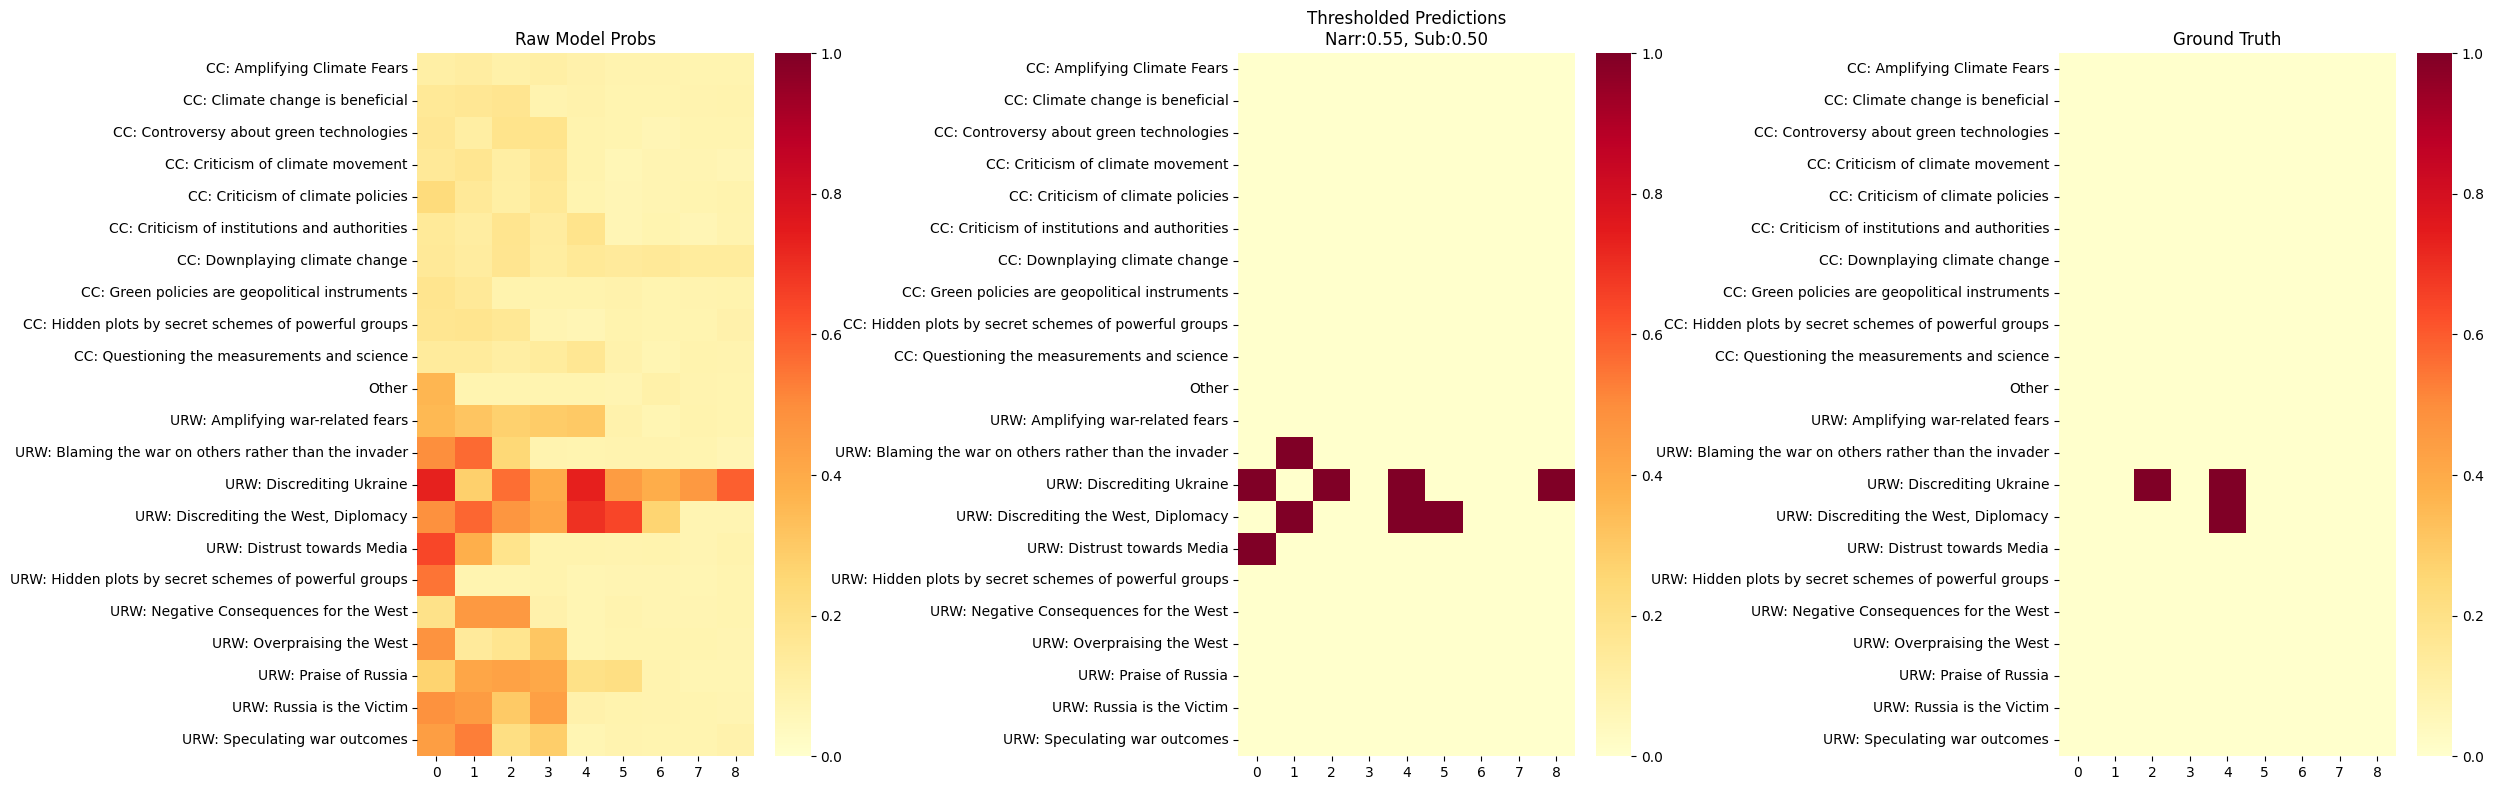


Article EN_CC_200030.txt


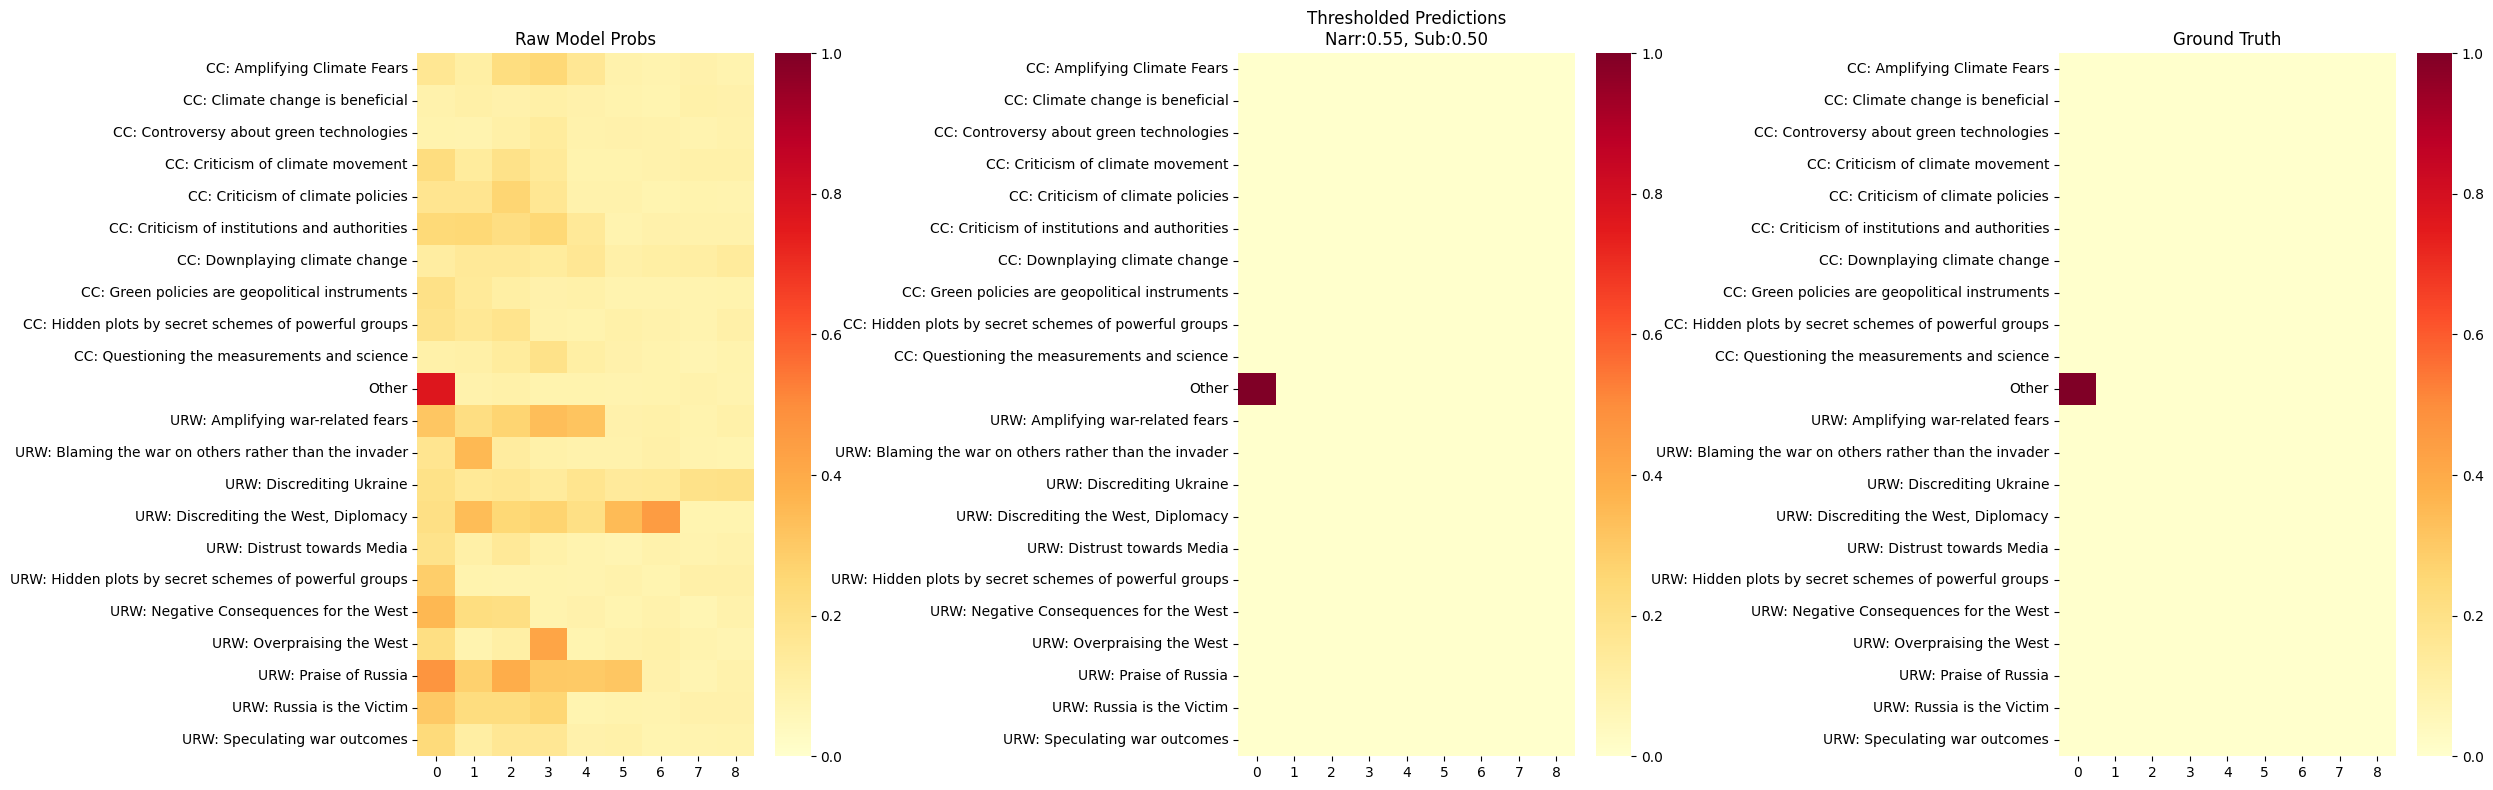


Article EN_CC_200053.txt


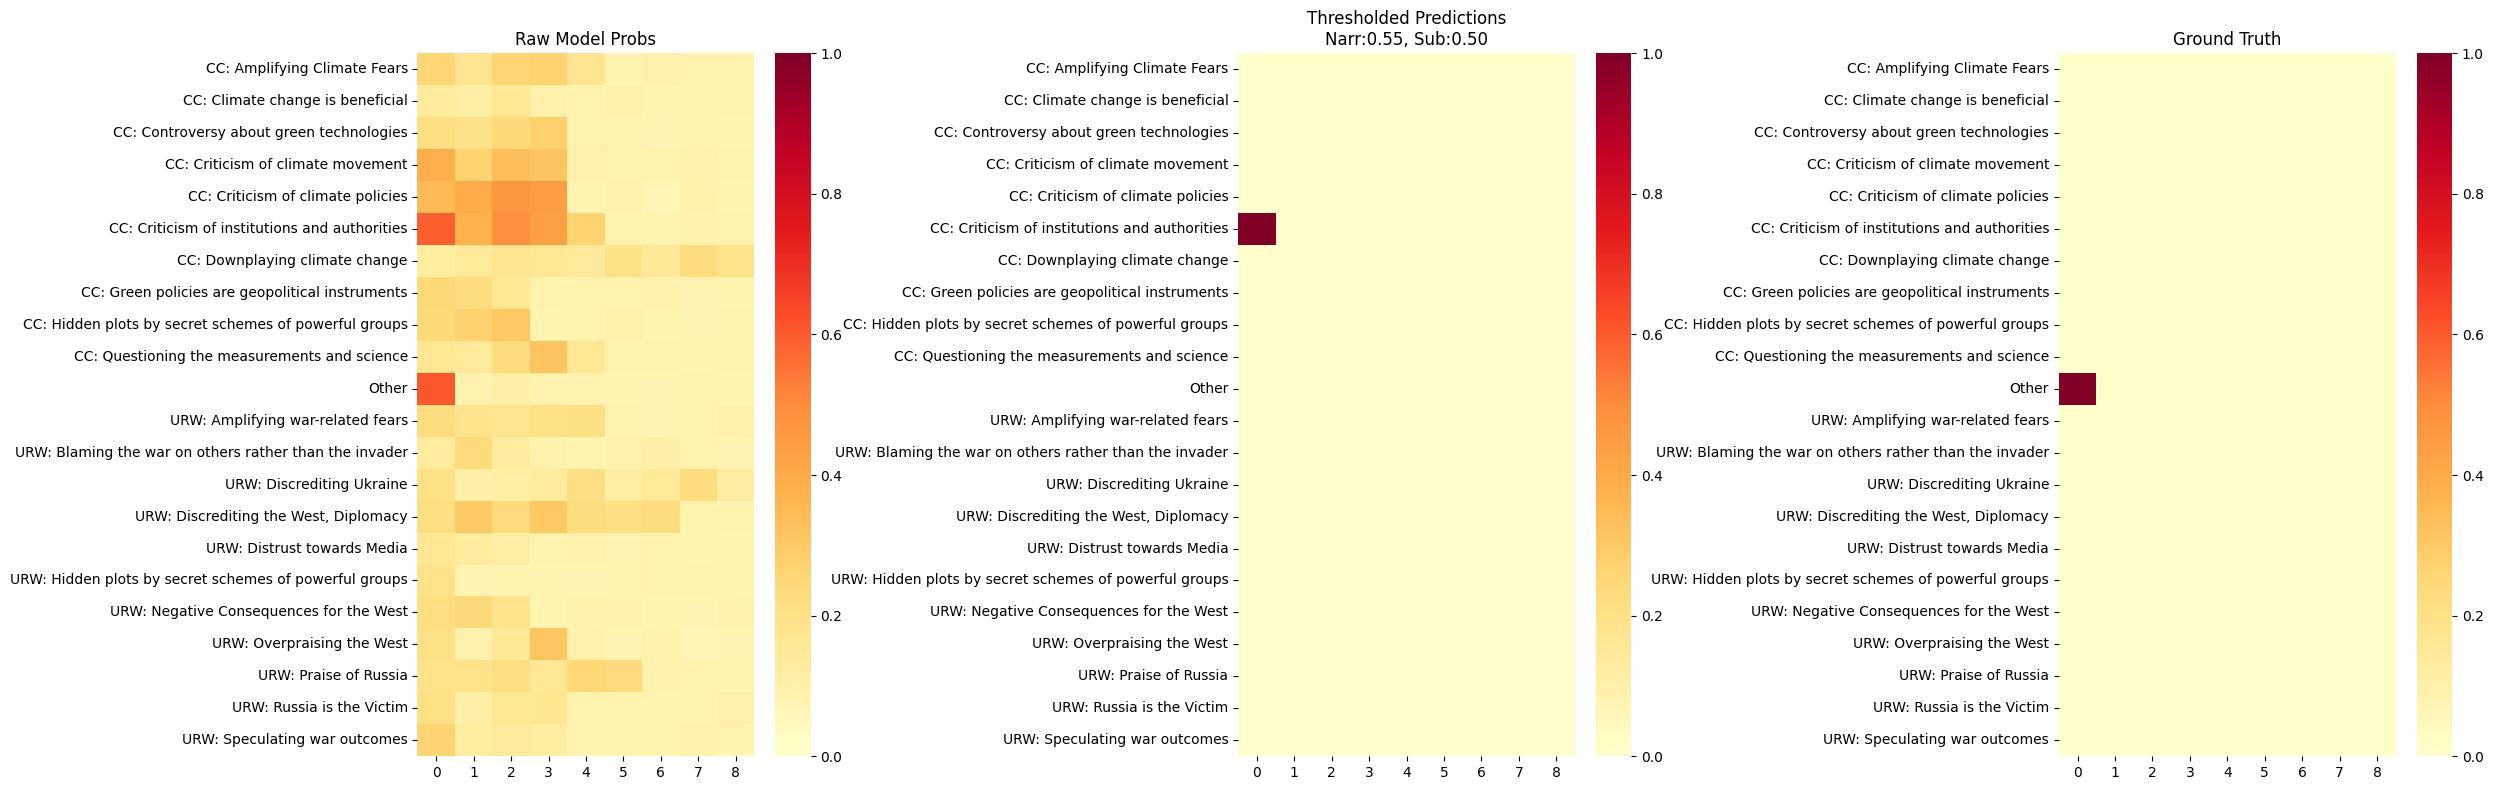


Article EN_UA_DEV_100034.txt


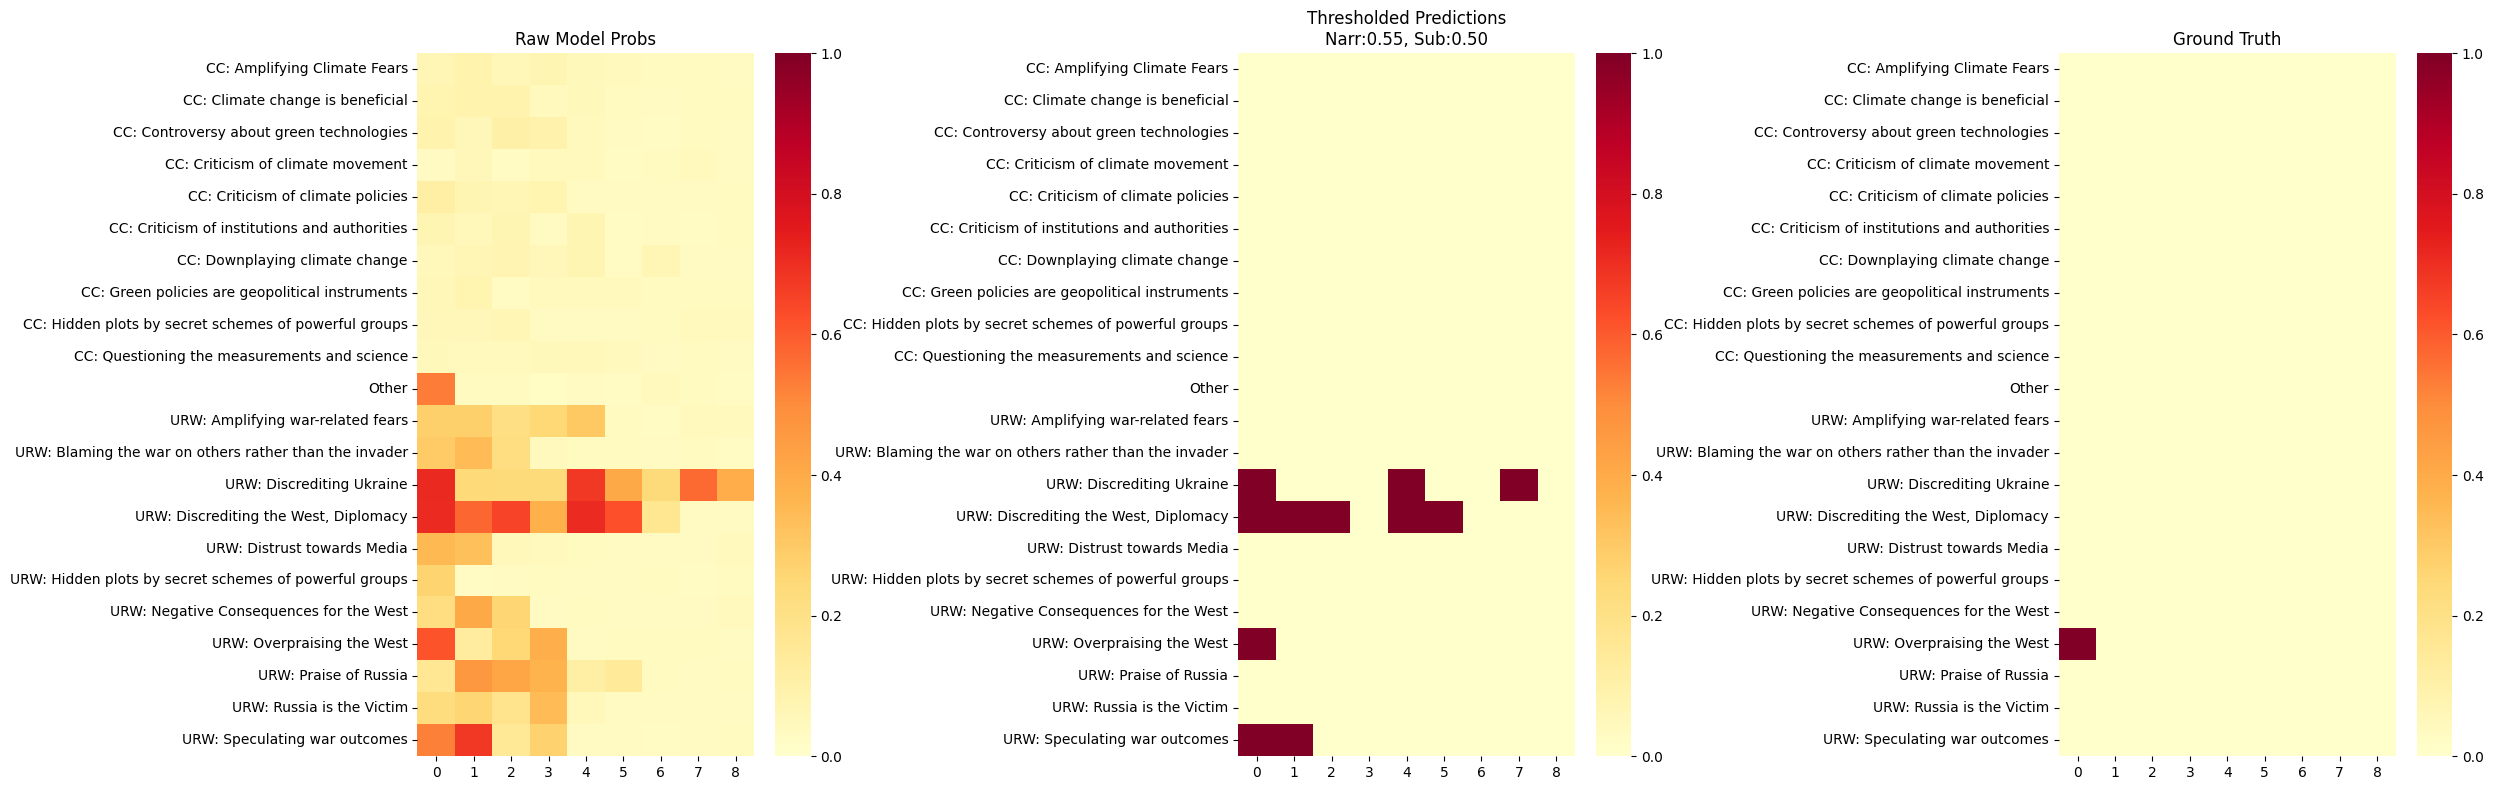


Article EN_UA_DEV_20.txt


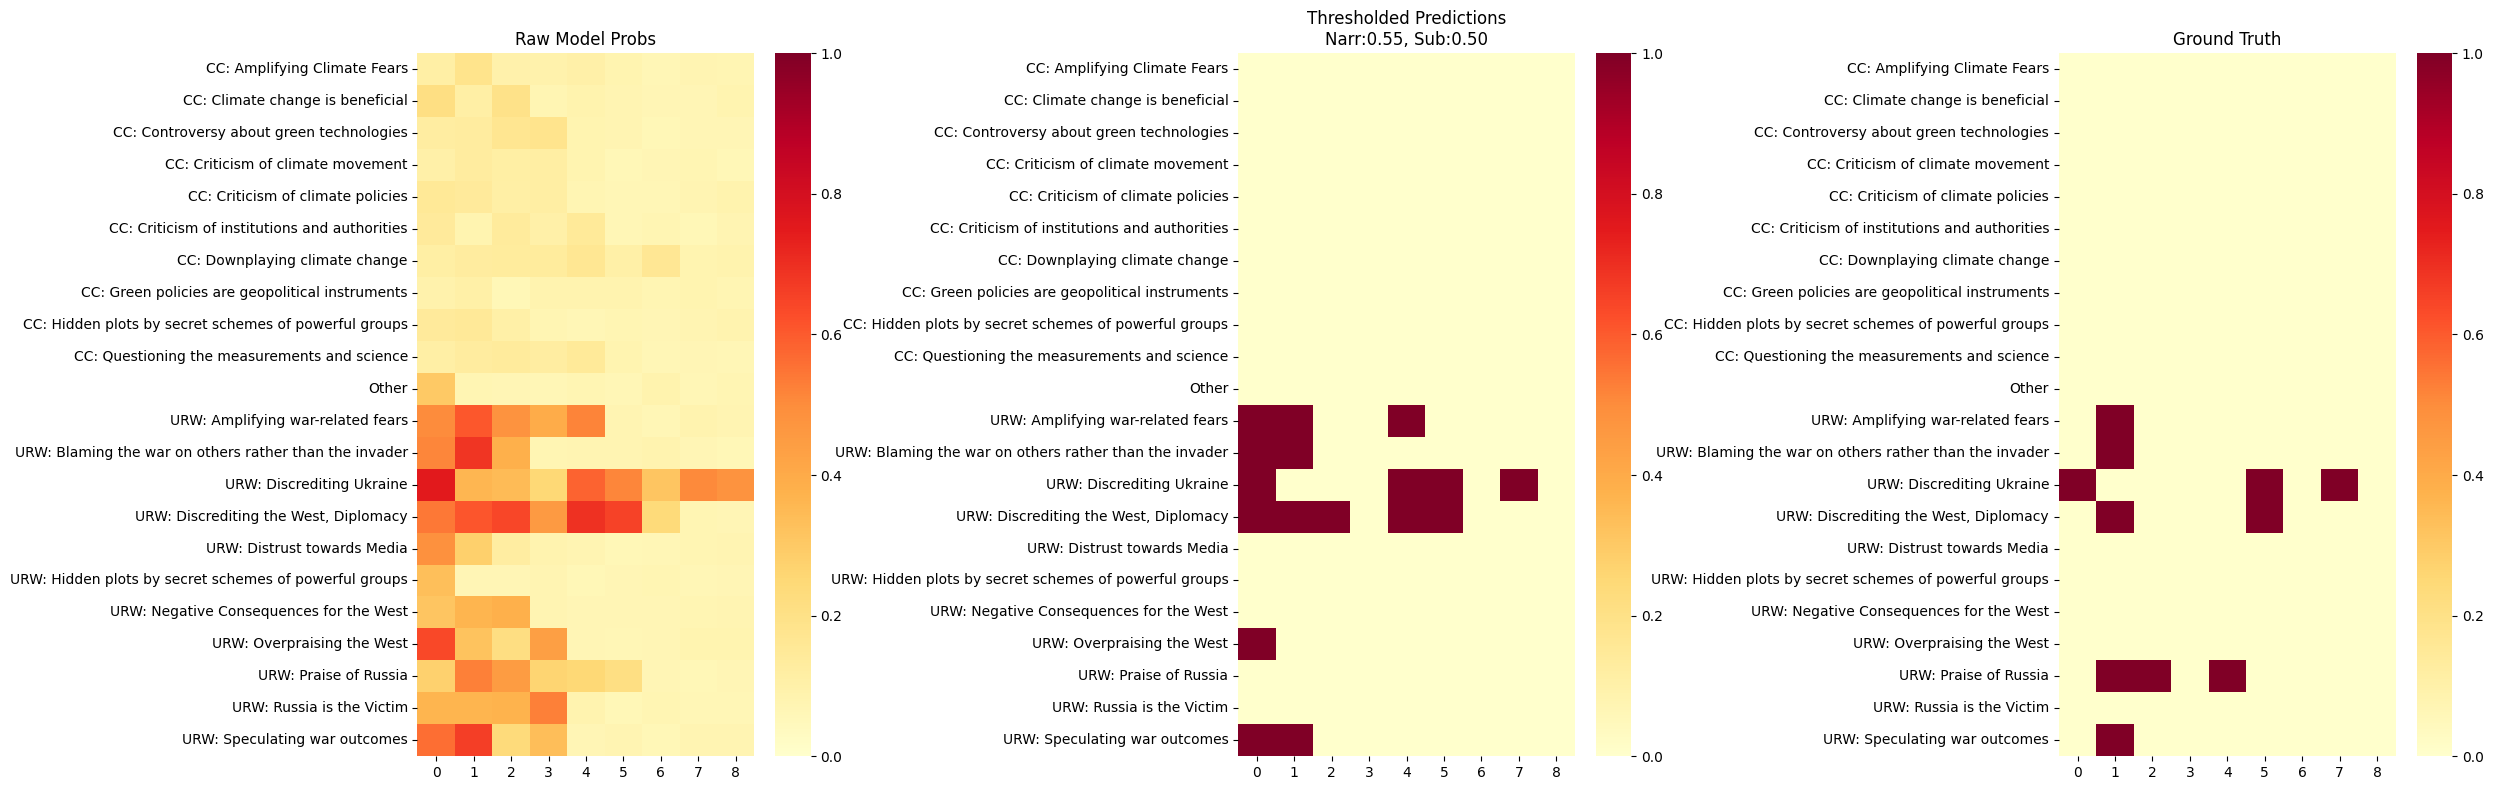


Article EN_UA_DEV_100013.txt


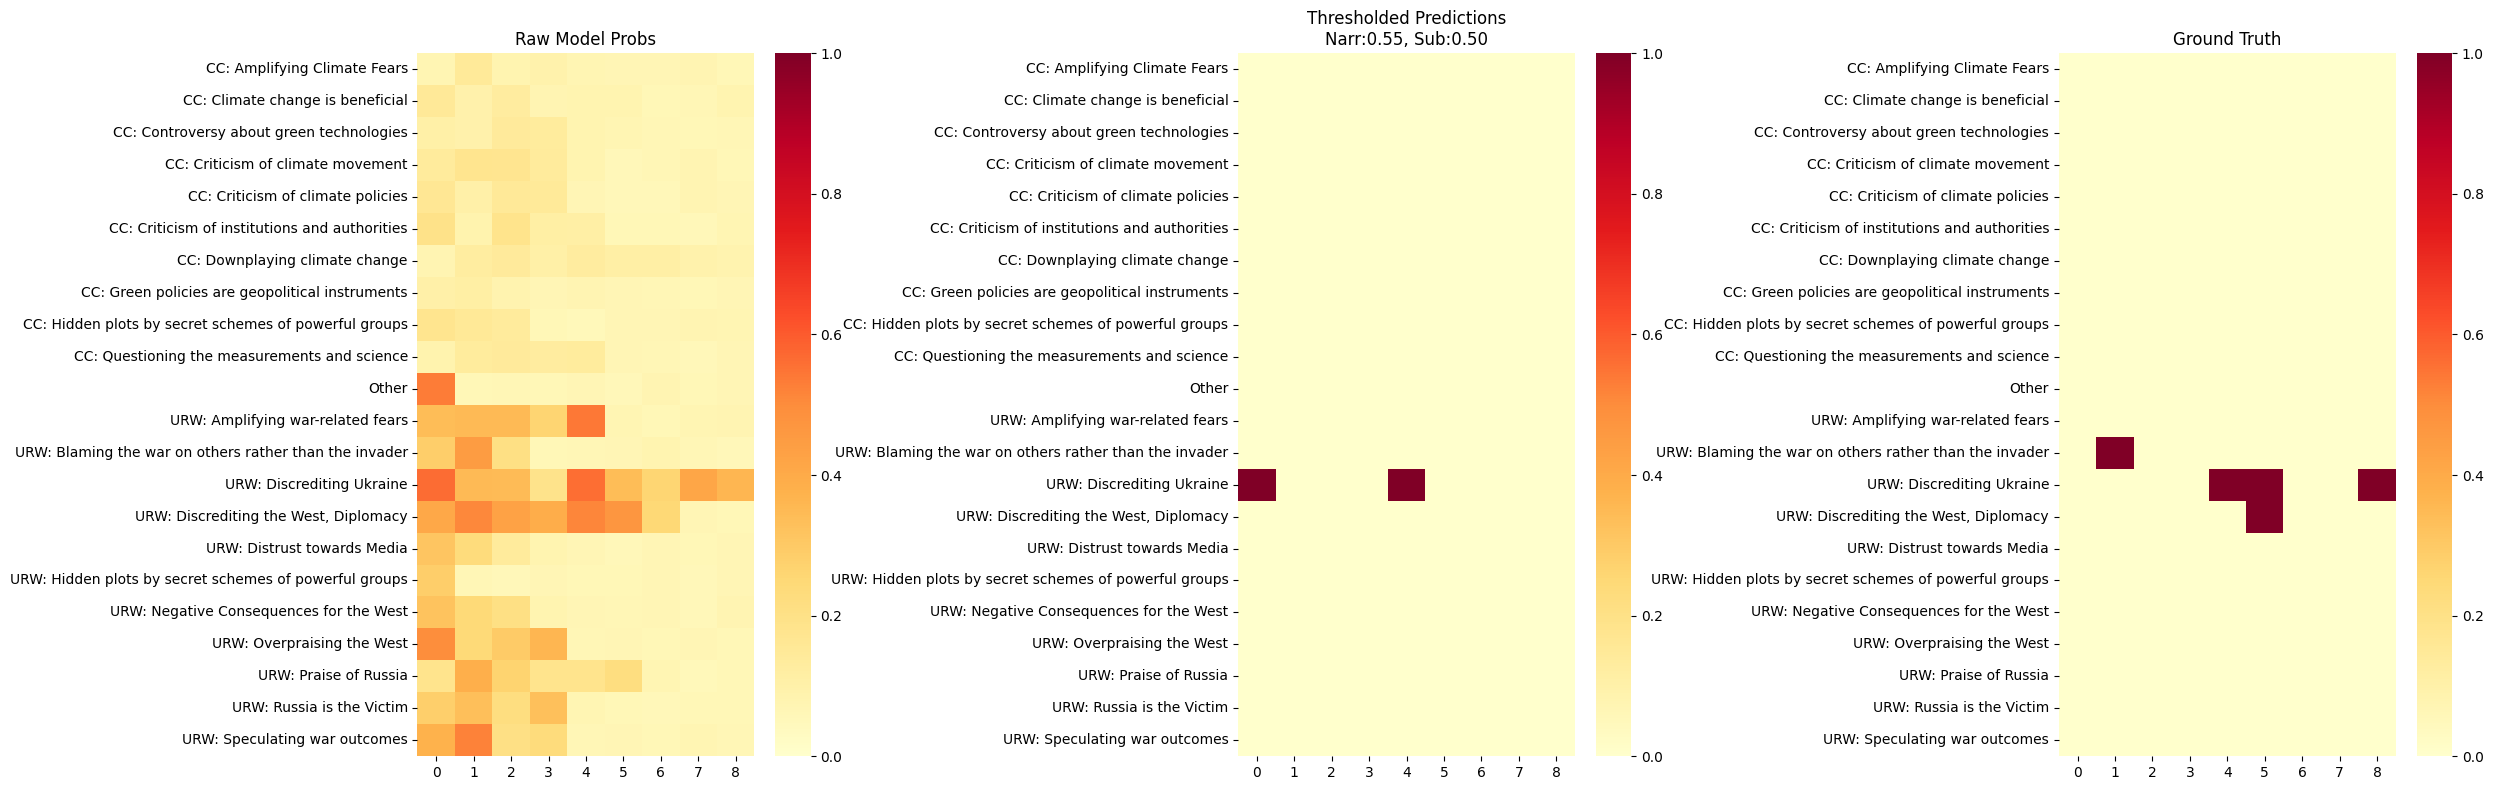


Article EN_CC_200065.txt


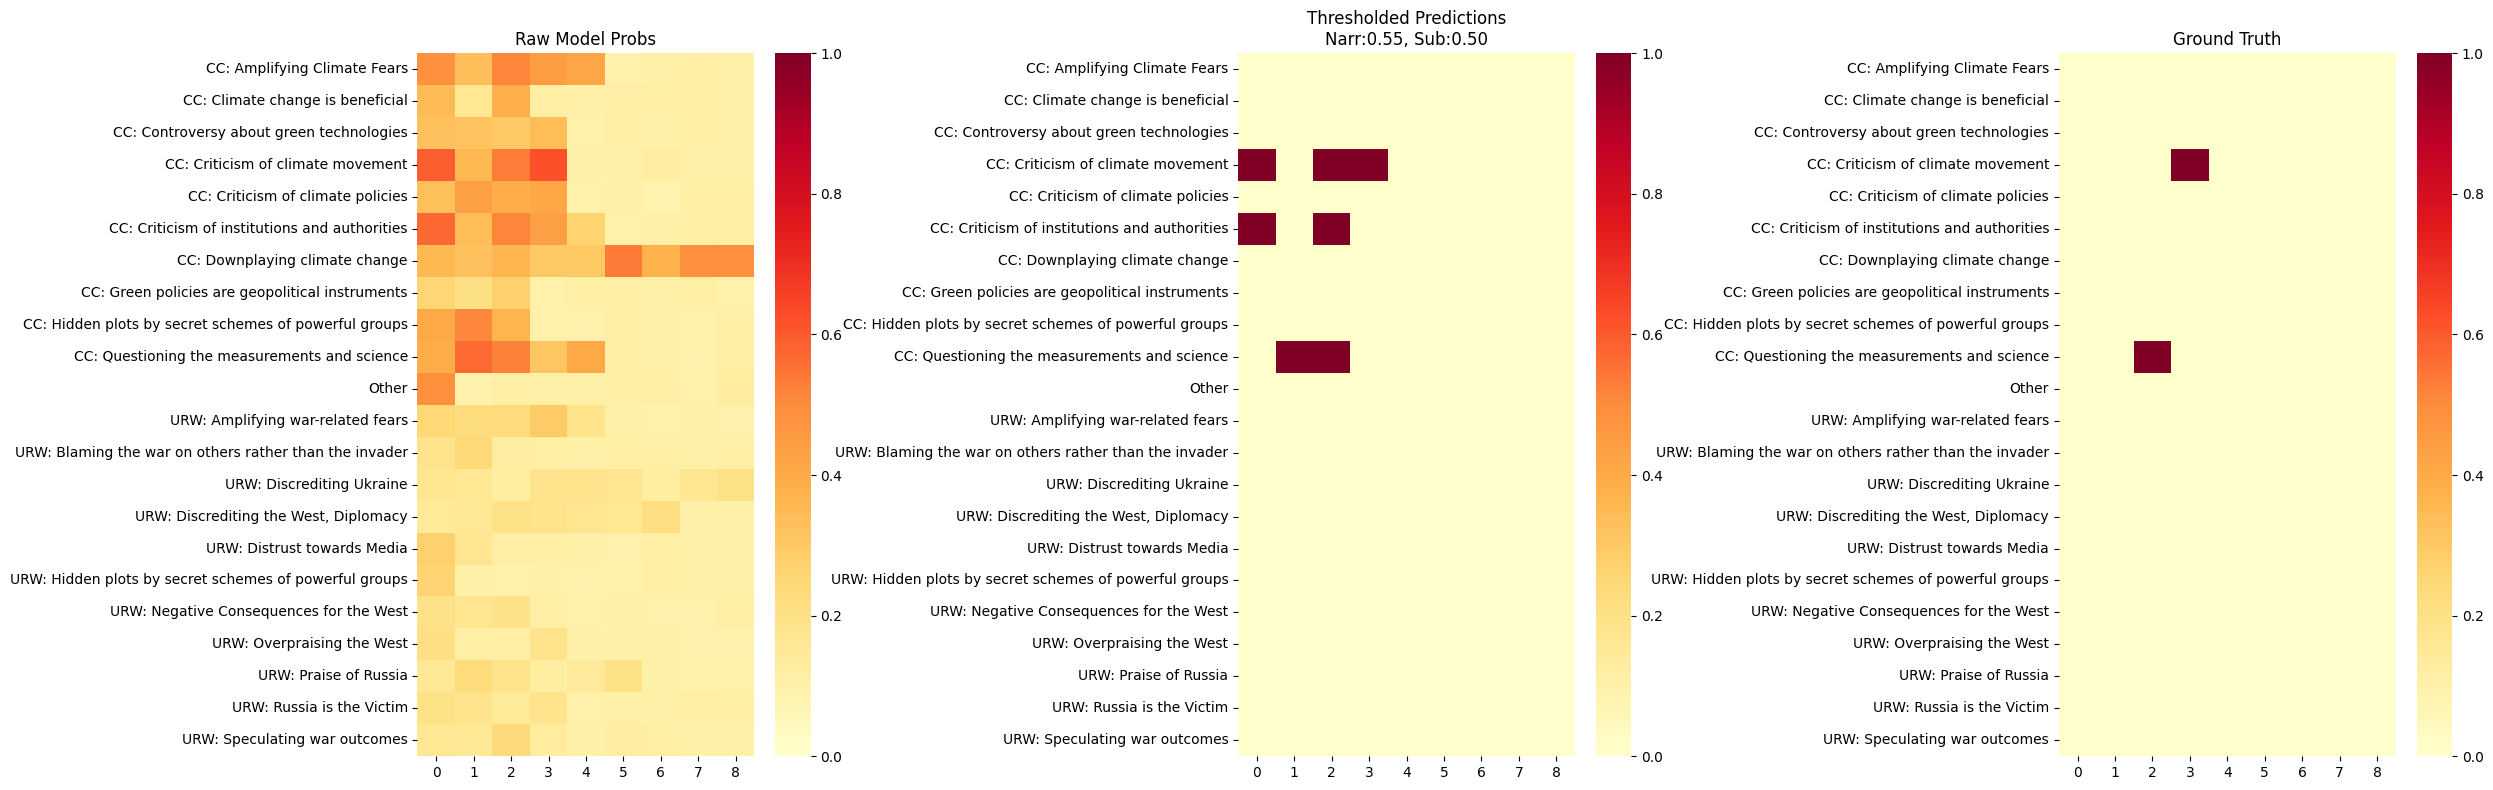


Article EN_CC_200047.txt


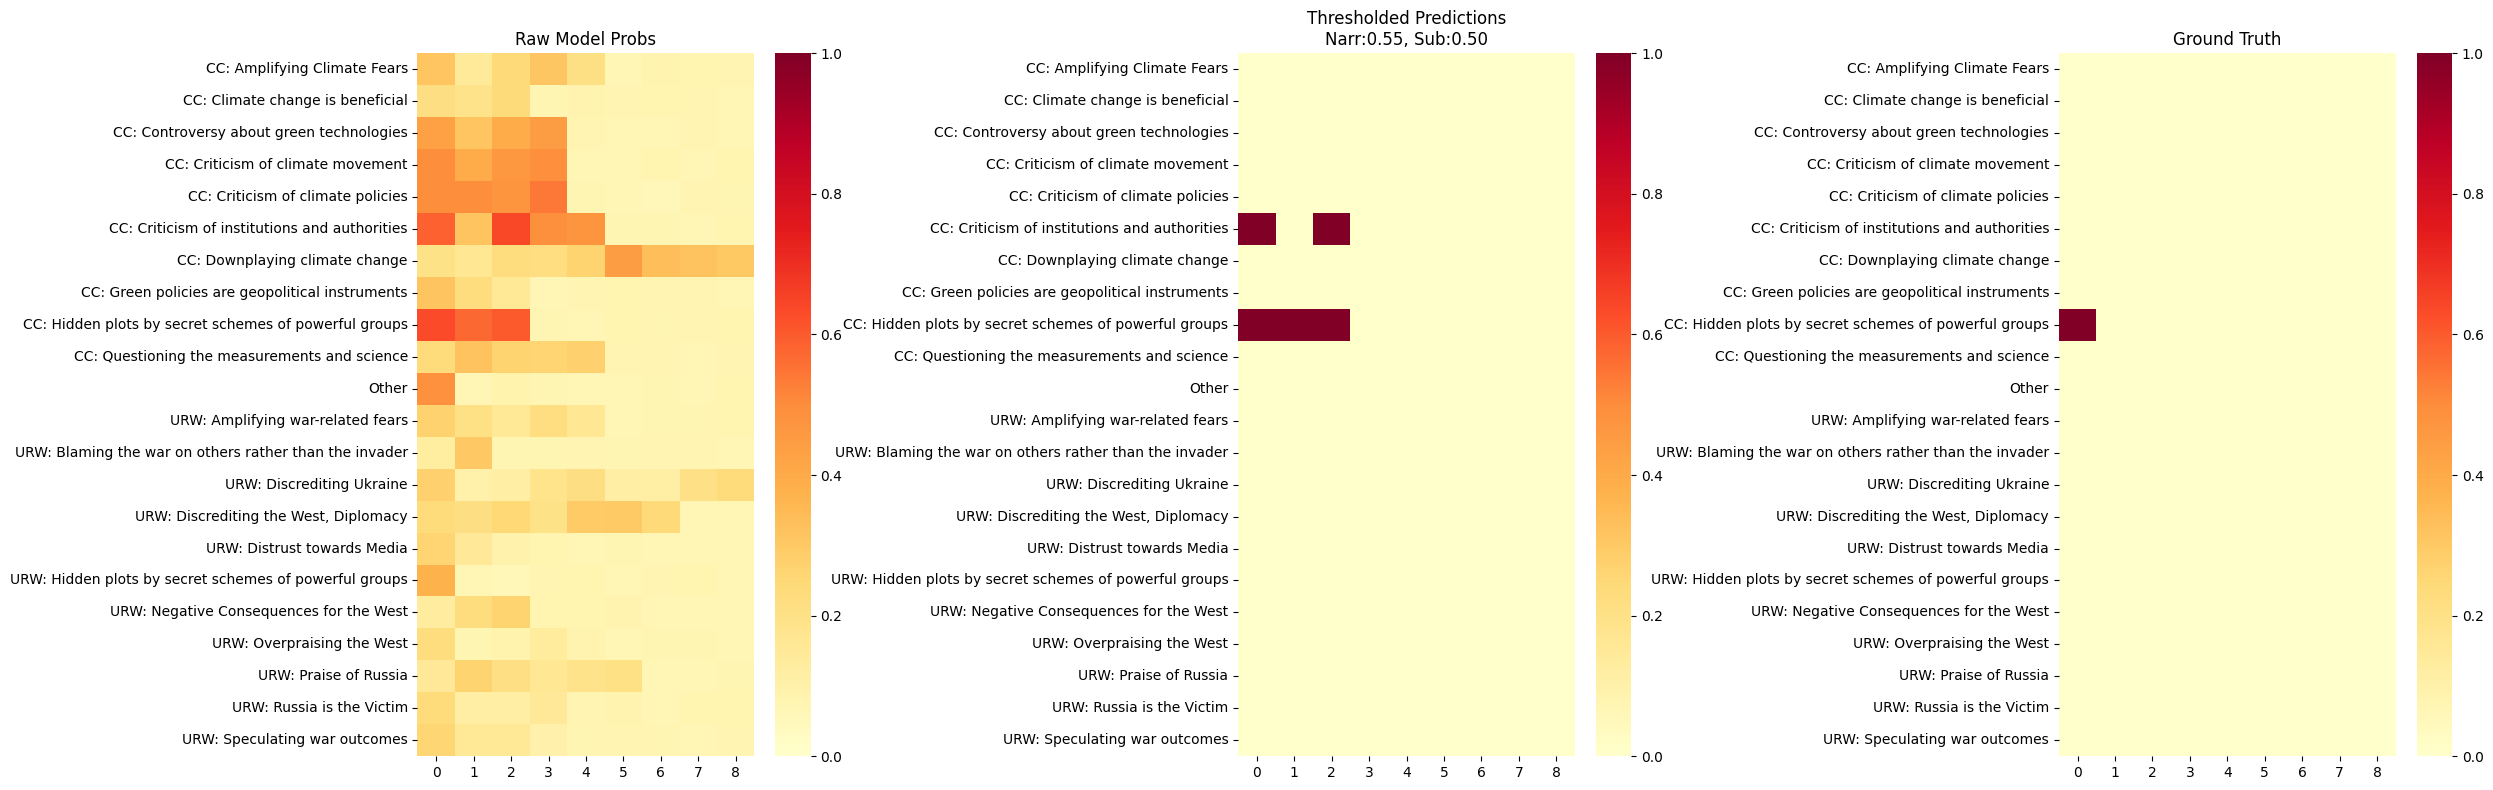


Article EN_CC_200036.txt


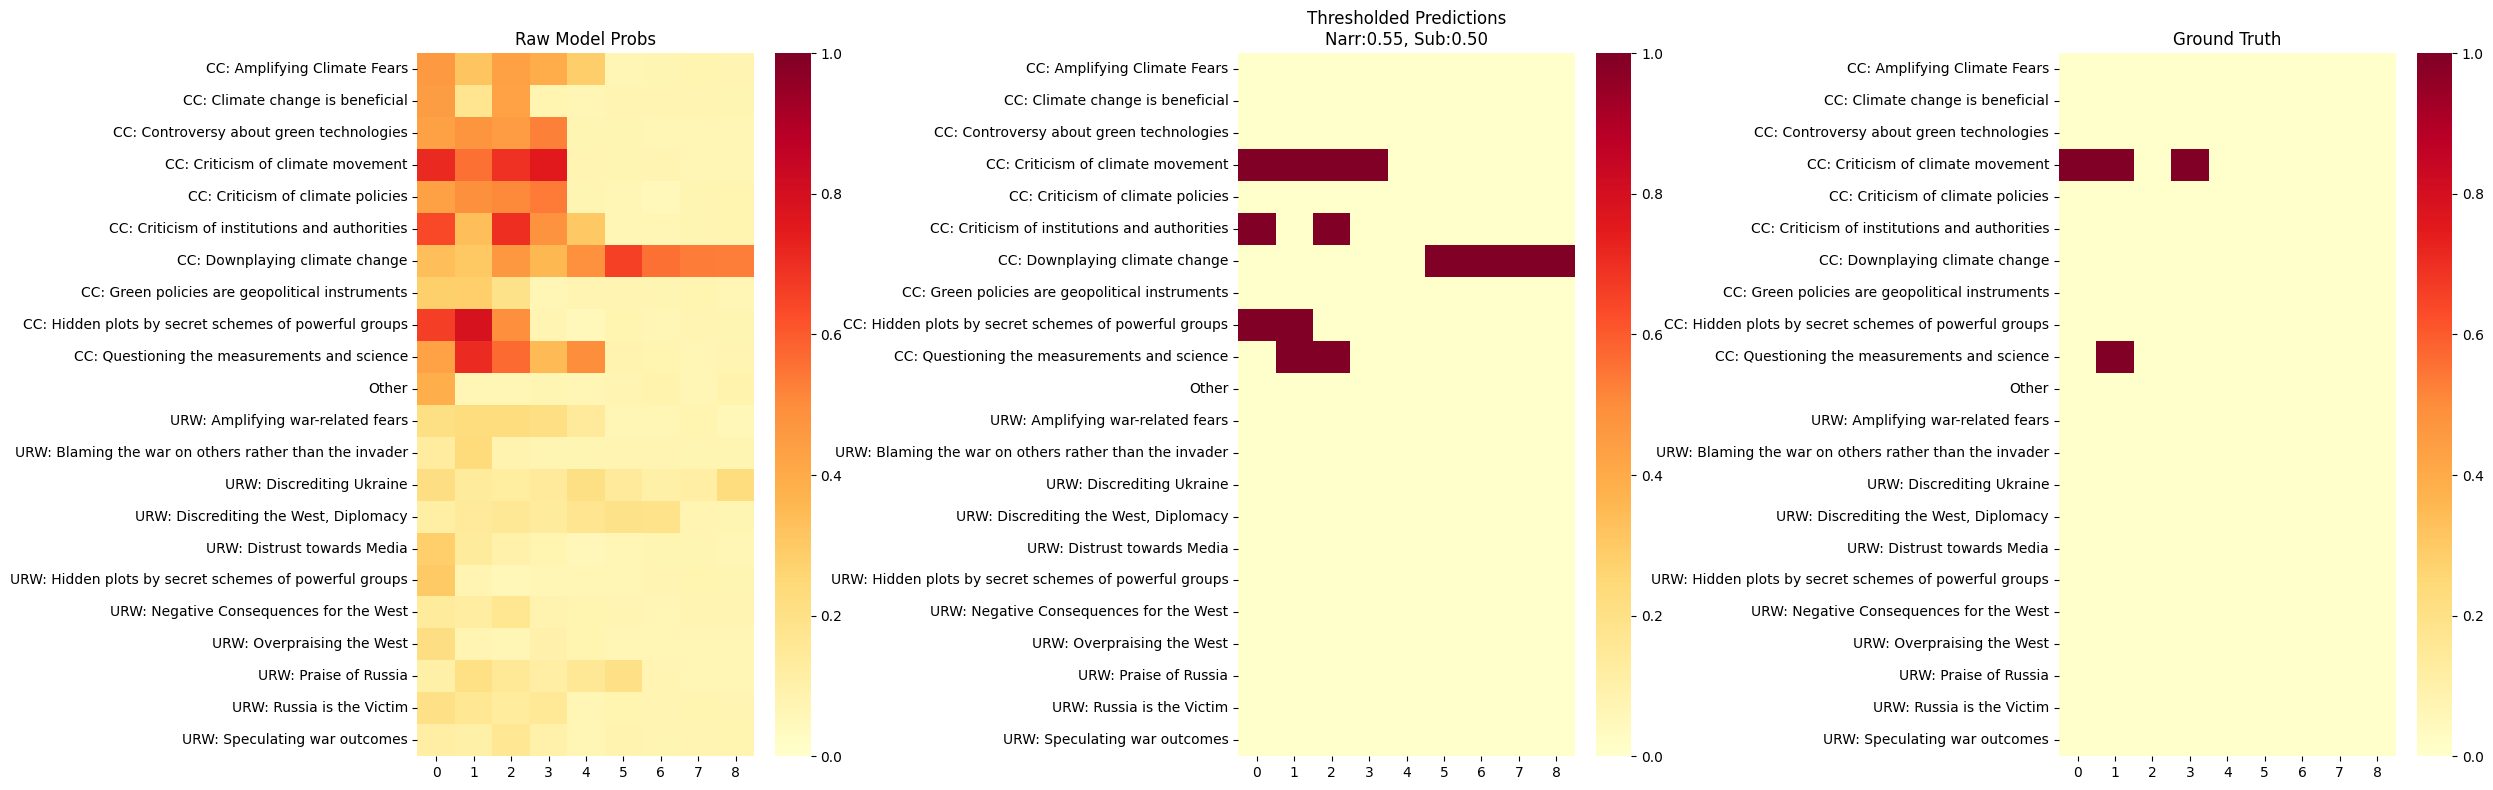


Article EN_UA_DEV_100005.txt


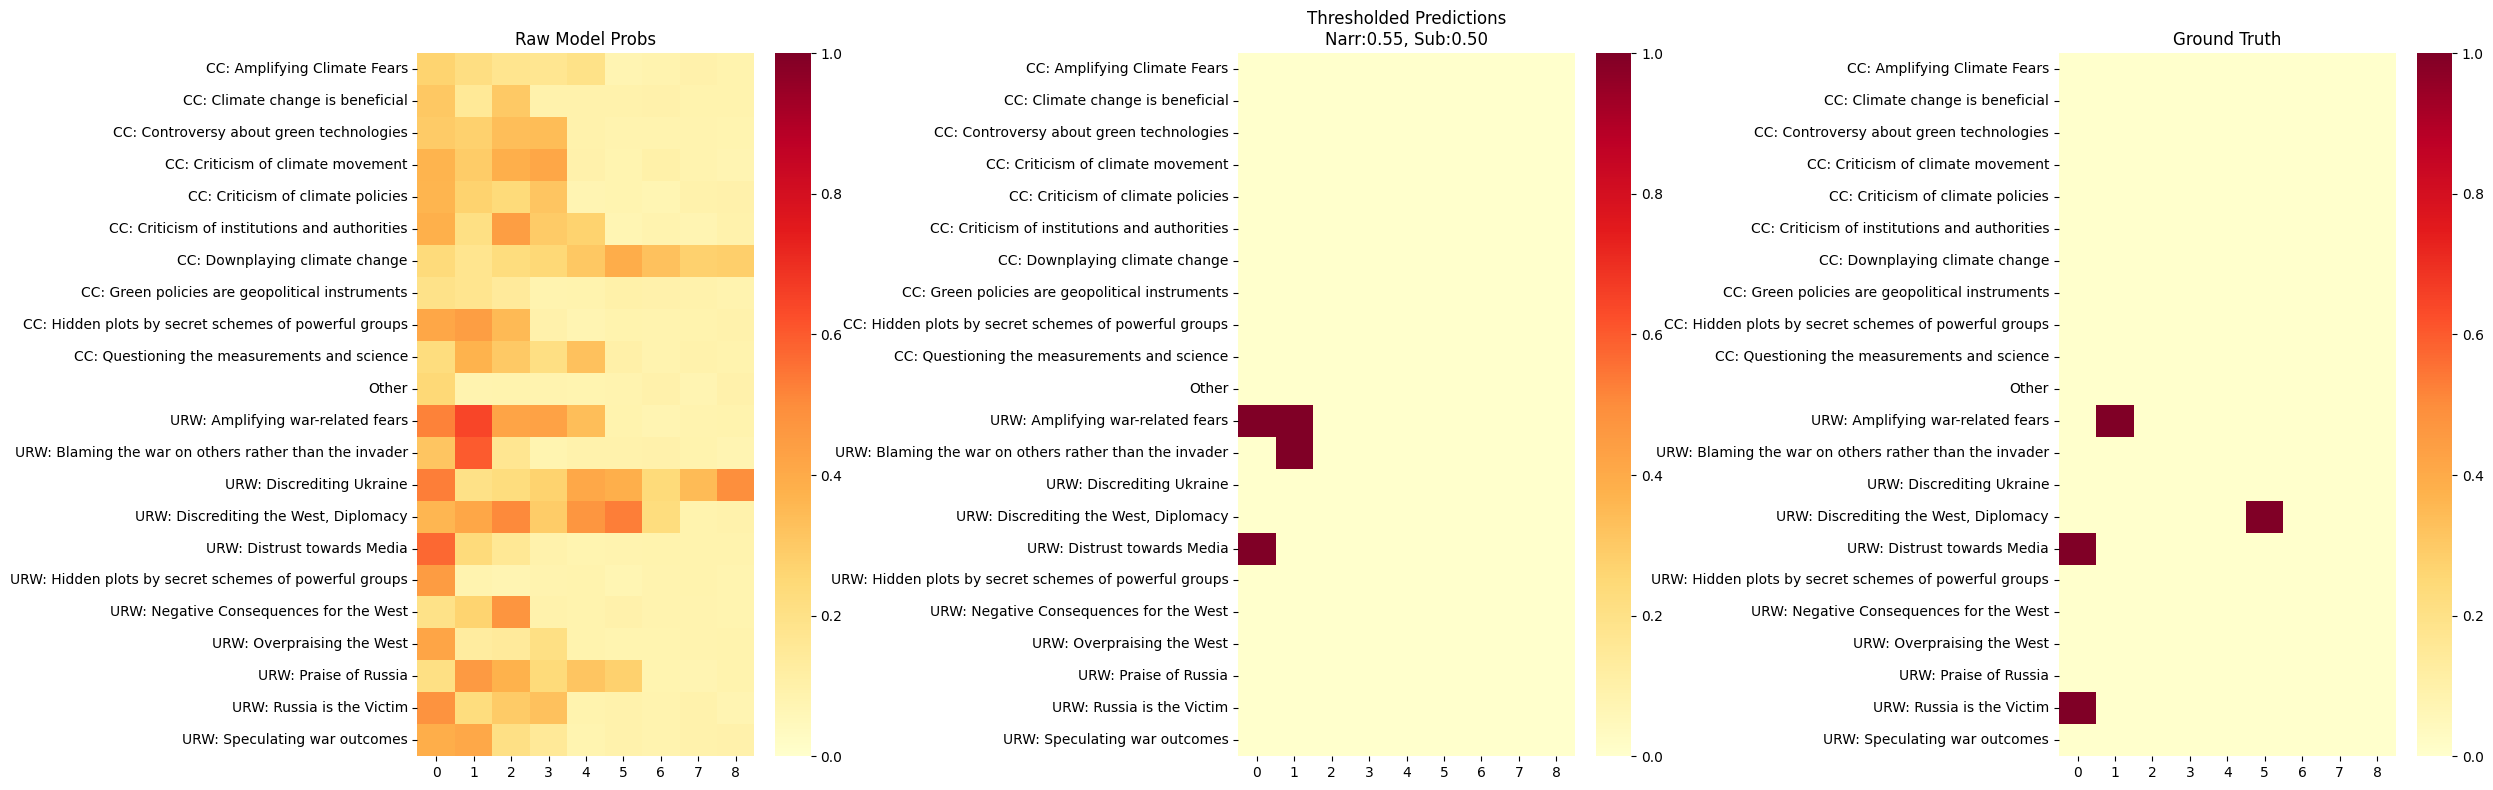

In [47]:
random_indices = np.random.choice(len(dataset_val), size=10, replace=False)

for article_idx in random_indices:
    print(f"\nArticle {dataset_val.iloc[article_idx]['article_id']}")
    plot_prediction_heatmap(
        preds_raw=preds,
        preds_thres=heatmap_pred_labels,
        trues=val_labels,
        article_idx=article_idx,
        narr_threshold=results['narr_threshold'],
        sub_threshold=results['sub_threshold']
    )